In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/TARP/datavis_data/

/content/gdrive/MyDrive/TARP/datavis_data


In [3]:
ls test/

'Copy of 0000007_05499_d_0000037.jpg'  'Copy of 0000008_03999_d_0000044.jpg'
'Copy of 0000008_00889_d_0000039.jpg'  'Copy of 0000013_00465_d_0000067.jpg'


In [4]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing 


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

In [5]:
XML_PATH = "annotation"
IMG_PATH = "train"
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]
XML_FILES = XML_FILES[:1000] #first 1000

len(XML_FILES)

1000

In [6]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = self.filter(xml_file)
        
        # path to the image file = name of annotation file
        self.img_name = xml_file.split('/')[1].split('.')[0]+".jpg";
        self.img_path = os.path.join(IMG_PATH, self.img_name)

        # image id 
        self.image_id = self.img_name.split('.')[0];

        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def filter(self,xml_file):

        filtered_data = []

        f = open(xml_file, 'r')

        for line in f:
            data = line.split(',')
            if data[5]!='0':
                data = [int(x.strip()) for x in data]
                filtered_data.append(data)

        return filtered_data

    def _get_names(self):

        label_dict = {
                      0 : "Ignore",
                      1 : "Pedestrian",
                      2 : "People",
                      3 : "Bicycle",
                      4 : "Car",
                      5 : "Van",
                      6 : "Truck",
                      7 : "Tricycle",
                      8 : "Awning-tricycle",
                      9 : "Bus",
                      10 : "Motor",
                      11 : "Others"
                    }

        names = []

        for data in self.xml_file:
              class_id = data[5]
              names.append(label_dict[class_id])

        return np.array(names)

    def _get_bndbox(self):

        boxes = []

        for data in self.xml_file:
            
            coordinates = []
            coordinates.append(np.int32(data[0])) #xmin
            coordinates.append(np.int32(np.float32(data[1]))) #ymin
            coordinates.append(np.int32(data[2]+data[0])) #xmax
            coordinates.append(np.int32(data[3]+data[1])) #ymax
            boxes.append(coordinates)

        return np.array(boxes)

# xml = XmlParser('Annotations/0000007_05999_d_0000038.txt')

In [7]:
def xml_files_to_df(xml_files):
    
    """"Return pandas dataframe from list of XML files."""
    
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"img_id": image_id,
         "names": names,
         "boxes": boxes,
         "xml_path":xml_path,
         "img_path":img_path}
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

df = xml_files_to_df(XML_FILES)
df.head()
df.shape[0]

65447

In [8]:
# check values for per class
df['names'].value_counts()

Car                27084
Pedestrian         12548
People              7404
Motor               7163
Van                 3826
Bicycle             2302
Tricycle            1903
Truck               1844
Awning-tricycle      693
Bus                  501
Others               179
Name: names, dtype: int64

In [9]:
df['boxes']

0           [203, 0, 231, 36]
1           [82, 16, 100, 39]
2           [91, 41, 116, 63]
3          [128, 30, 153, 55]
4          [149, 21, 161, 37]
                 ...         
65442    [272, 158, 284, 184]
65443    [266, 180, 279, 206]
65444    [301, 212, 326, 236]
65445    [287, 201, 315, 224]
65446    [289, 208, 301, 227]
Name: boxes, Length: 65447, dtype: object

In [10]:
# classes need to be in int form so we use LabelEncoder for this task
enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['names'])
df['labels'] = np.stack(df['labels'][i]+1 for i in range(len(df['labels']))) 

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
classes = df[['names','labels']].value_counts()
classes

names            labels
Car              4         27084
Pedestrian       7         12548
People           8          7404
Motor            5          7163
Van              11         3826
Bicycle          2          2302
Tricycle         9          1903
Truck            10         1844
Awning-tricycle  1           693
Bus              3           501
Others           6           179
dtype: int64

In [12]:
df.head()

,img_id,names,boxes,xml_path,img_path,labels
0,0000205_02315_d_0000202,Van,"[203, 0, 231, 36]","[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,11
1,0000205_02315_d_0000202,Awning-tricycle,"[82, 16, 100, 39]","[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,1
2,0000205_02315_d_0000202,Tricycle,"[91, 41, 116, 63]","[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,9
3,0000205_02315_d_0000202,Car,"[128, 30, 153, 55]","[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,4
4,0000205_02315_d_0000202,Pedestrian,"[149, 21, 161, 37]","[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,7


In [13]:
classes = {
                      0 : "Ignore",
                      1 : "Pedestrian",
                      2 : "People",
                      3 : "Bicycle",
                      4 : "Car",
                      5 : "Van",
                      6 : "Truck",
                      7 : "Tricycle",
                      8 : "Awning-tricycle",
                      9 : "Bus",
                      10 : "Motor",
                      11 : "Others"
                    }

In [14]:
#bounding box coordinates point need to be in separate columns

df['xmin'] = -1
df['ymin'] = -1
df['xmax'] = -1
df['ymax'] = -1

df[['xmin','ymin','xmax','ymax']]=np.stack(df['boxes'][i] for i in range(len(df['boxes'])))

df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
# drop names column since we dont need it anymore
df.drop(columns=['names'], inplace=True)
df.head()

,img_id,xml_path,img_path,labels,xmin,ymin,xmax,ymax
0,0000205_02315_d_0000202,"[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,11,203.0,0.0,231.0,36.0
1,0000205_02315_d_0000202,"[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,1,82.0,16.0,100.0,39.0
2,0000205_02315_d_0000202,"[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,9,91.0,41.0,116.0,63.0
3,0000205_02315_d_0000202,"[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,4,128.0,30.0,153.0,55.0
4,0000205_02315_d_0000202,"[[203, 0, 28, 36, 1, 5, 1, 0], [82, 16, 18, 23...",train/0000205_02315_d_0000202.jpg,7,149.0,21.0,161.0,37.0


In [16]:
len(df['img_id'].unique())

1000

In [17]:
image_ids = df['img_id'].unique()
valid_ids = image_ids[-4:]
train_ids = image_ids[:-4]
len(train_ids)

996

In [18]:
valid_df = df[df['img_id'].isin(valid_ids)]
train_df = df[df['img_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((491, 8), (64956, 8))

In [19]:
!pip install -q albumentations
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from albumentations import RandomRotate90
from tensorflow.keras import mixed_precision
import gc

In [20]:
def func(image):
    Trgb2lms =np.array( [
          np.array([17.8824, 43.5161, 4.1194]),
          np.array([3.4557,27.1154, 3.8671]),
          np.array([0.0300, 0.1843, 1.4671]) 
      ])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x,y,z = image.shape
#     print(image.shape)
    cvd_due = np.array([
                     np.array([1 ,0, 0]),   
                     np.array([0.494207, 0, 1.24827]),   
                     np.array([0, 0, 1]),   
    ])
    INV_Trgb2lms = np.linalg.inv(Trgb2lms) 

#     print(image.transpose(2, 0, 1).shape)
    out = np.dot(INV_Trgb2lms, cvd_due)
    out = np.dot(out, Trgb2lms)
    out = np.dot(out, image.transpose(2, 0, 1).reshape(3,-1)) 
    out = out.reshape(3,x,y).transpose(1, 2, 0)
    out = cv2.cvtColor(np.float32(out), cv2.COLOR_RGB2BGR)

    return out
  

In [21]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = func(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
       
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [22]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, IMG_PATH , get_transform_train())
valid_dataset = VOCDataset(valid_df, IMG_PATH, get_transform_valid())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

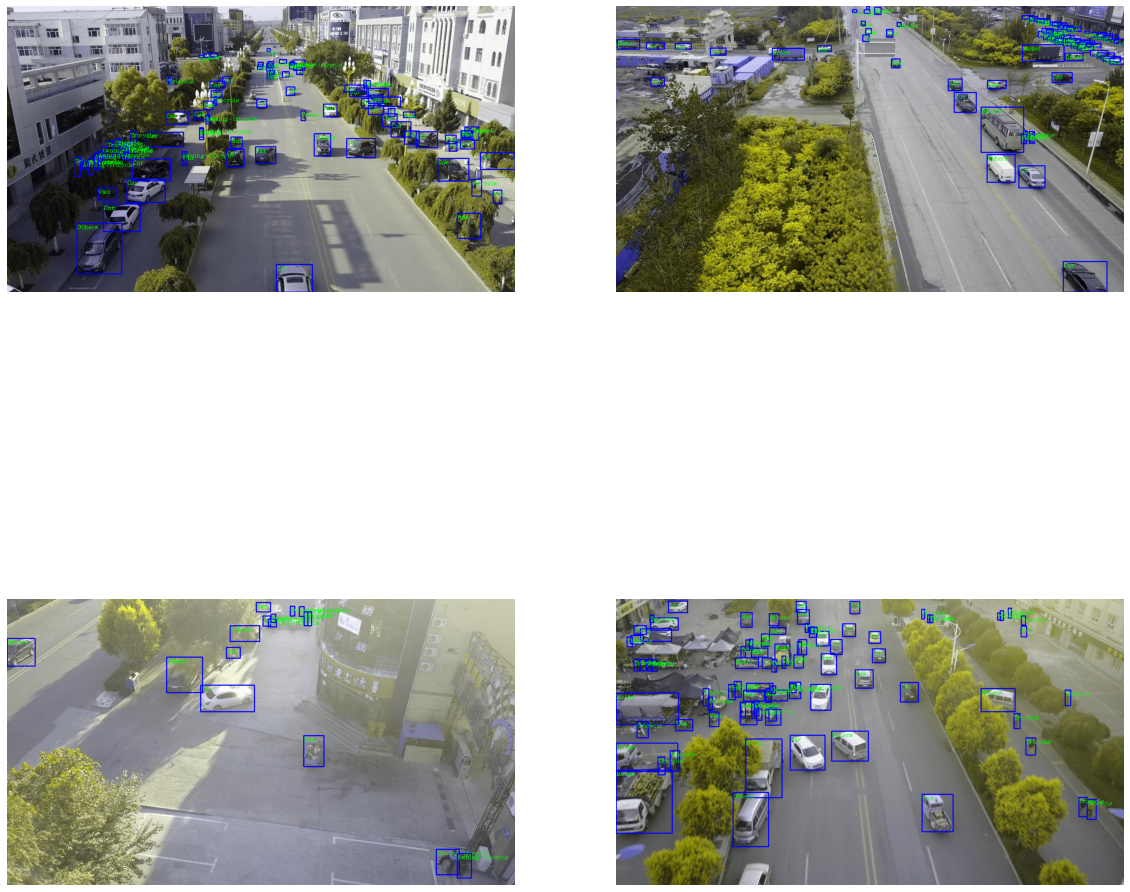

In [25]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
    

In [26]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [27]:
num_classes = 12

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [28]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [29]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_qnr0xg4
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_qnr0xg4
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp39-cp39-linux_x86_64.whl size=397874 sha256=bcb0354e432218b4f38951f3ef9632c3759ec13d0645de9bea23d49b1bb5fc0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-b7orro89/wheels/13/c1/d6/a321055f7089f1a6af654fbf794536b196999f082a9cb68a37
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [30]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [31]:
from engine import train_one_epoch, evaluate
import utils

In [32]:
%%time
# let's train it for 2 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [  0/249]  eta: 1:02:59  lr: 0.000025  loss: 3.5922 (3.5922)  loss_classifier: 2.3651 (2.3651)  loss_box_reg: 0.7154 (0.7154)  loss_objectness: 0.2293 (0.2293)  loss_rpn_box_reg: 0.2824 (0.2824)  time: 15.1800  data: 3.0740  max mem: 5582
Epoch: [0]  [ 10/249]  eta: 0:10:38  lr: 0.000227  loss: 3.5940 (3.6805)  loss_classifier: 2.3173 (2.3134)  loss_box_reg: 0.7680 (0.7617)  loss_objectness: 0.2819 (0.3764)  loss_rpn_box_reg: 0.2519 (0.2289)  time: 2.6722  data: 0.3401  max mem: 6358
Epoch: [0]  [ 20/249]  eta: 0:07:43  lr: 0.000428  loss: 3.4573 (3.5183)  loss_classifier: 2.2208 (2.1767)  loss_box_reg: 0.7591 (0.7507)  loss_objectness: 0.2819 (0.3486)  loss_rpn_box_reg: 0.2370 (0.2422)  time: 1.3663  data: 0.0614  max mem: 7054
Epoch: [0]  [ 30/249]  eta: 0:06:32  lr: 0.000629  loss: 3.1340 (3.3055)  loss_classifier: 1.7346 (1.9702)  loss_box_reg: 0.7103 (0.7379)  loss_objectness: 0.2548 (0.3432)  loss_rpn_box_reg: 0.2474 (0.2543)  time: 1.3112  data: 0.0466  max mem: 1160

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:  [0/1]  eta: 0:00:01  model_time: 0.5602 (0.5602)  evaluator_time: 0.3993 (0.3993)  time: 1.5954  data: 0.6221  max mem: 11609
Test: Total time: 0:00:01 (1.7191 s / it)
Averaged stats: model_time: 0.5602 (0.5602)  evaluator_time: 0.3993 (0.3993)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.9

In [33]:
torch.save(model.state_dict(), 'faster_rcnn_state.pth')

In [34]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "./faster_rcnn_state.pth"

num_classes = 12

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to pass

In [35]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

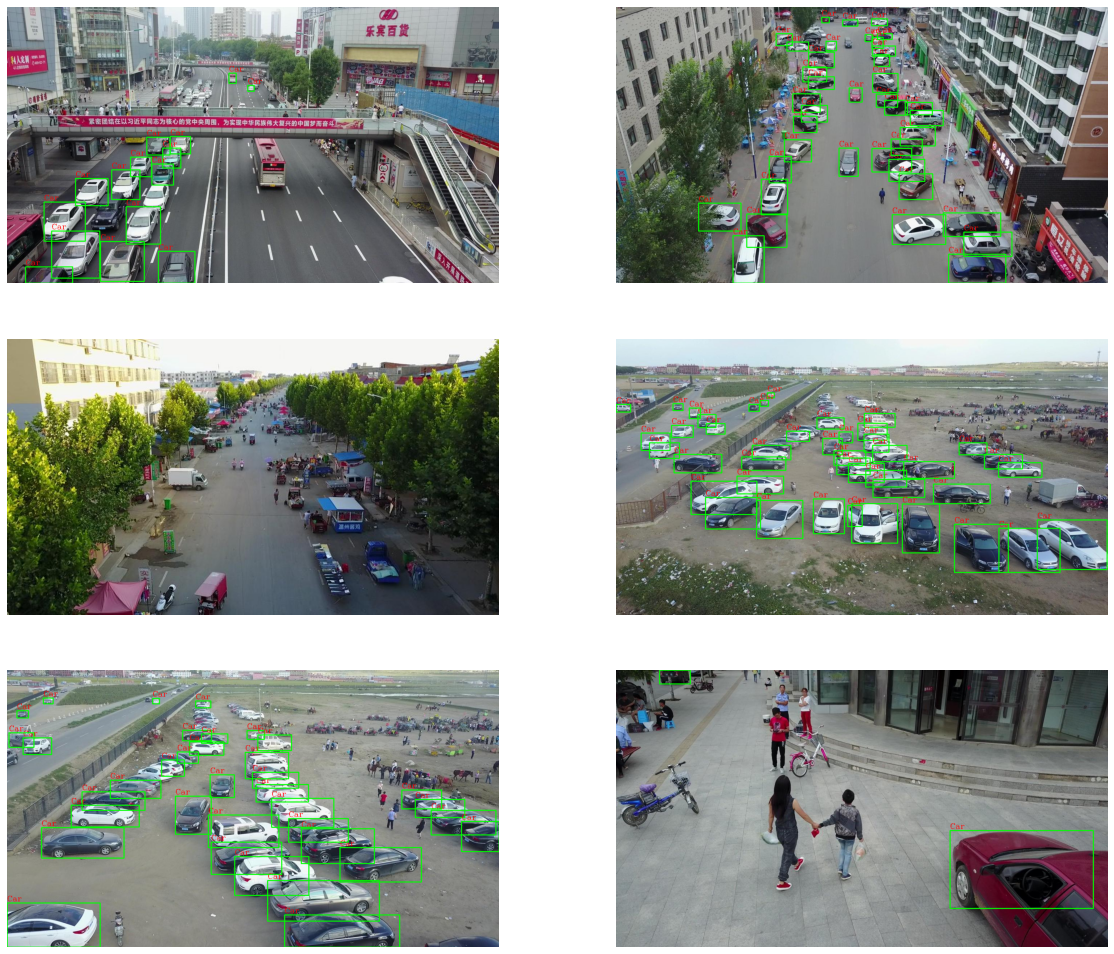

In [37]:
pred_path = "./test"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result